<font size="30">---------------</font>
<font size="30">Data processing</font>
<font size="30">---------------</font>

<font size="30">1.0 Prepare data</font>

In [2]:
from pymongo import MongoClient

try: 
    client = MongoClient()
    print("Connected successfully!!!") 
except:
    print("Could not connect to MongoDB") 

db = client.job_advert_db #select database
collection = db.job_advert #select collection to insert

Connected successfully!!!


In [3]:
 from bson.json_util import dumps

In [14]:
job_advert_collection = collection.find({})
print("Amount of data collected:" , job_advert_collection.count())

job_adverts = []

for ja in job_advert_collection:
    job_adverts.append(ja['desc'])

C:\Users\uSER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


Amount of data collected: 4827


<font size="30">2.0 Data Preprocessing</font>

In [5]:
import re, string, unicodedata
import nltk
import contractions #expand the contractions "you're -> you are"
import inflect #convert plural to singular nouns
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords #filter english words "is", "this", "there", etc.
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import tqdm

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uSER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uSER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uSER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

2.1 Denoise Job Descriptions

In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    processed_text = []
    pbar = tqdm.tqdm(total=len(text))
    for t in text:
        text = strip_html(t)
        text = remove_between_square_brackets(t)
        processed_text.append(text)
        pbar.update(1)
    pbar.close()
    return processed_text

In [18]:
job_adverts = denoise_text(job_adverts)

100%|████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:00<00:00, 8436.63it/s]


2.2 Replace contractions in string

In [19]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    text_arr = []
    pbar = tqdm.tqdm(total=len(text))
    for t in text:
        t = contractions.fix(t)
        text_arr.append(t)
        pbar.update(1)
    pbar.close()
    return text_arr

In [20]:
job_adverts = replace_contractions(job_adverts)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:51<00:00, 93.98it/s]


In [21]:
len(job_adverts)
print(job_adverts[:2])

['Leading Local EnterpriseUnderstand current processes and valuable outcomesAble to structure a large amount of information within a process frameworkJob scopeMapping/Reviewing existing business processes and “re-imagine” improved ones by maximizing customer value while minimizing waste and incorporating automation.Facilitate/lead process workshops that involve eliciting process requirements and liaising with usersAbility to interpret business requirements into digital solution.Create project plans that contain project goals, milestones, and resourcesMonitor, measure and provide feedback on process performanceLiaise with management to coordinate process improvement project activitiesRequirements:Enjoys variety at work as this is a wide-ranging role immersing in a variety of different projects, and able see the big picture.Work with other business teams and Digital Department to figure out the best way to design new processes and solve process-related problems.Strong analytical backgrou

2.3 Tokenization

In [22]:
temp_arr = []
pbar = tqdm.tqdm(total=len(job_adverts))
for ja in job_adverts:
    temp_arr.append(nltk.word_tokenize(ja))
    pbar.update(1)
job_adverts = temp_arr
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:19<00:00, 245.98it/s]


In [23]:
len(job_adverts)
print(job_adverts[:2])

[['Leading', 'Local', 'EnterpriseUnderstand', 'current', 'processes', 'and', 'valuable', 'outcomesAble', 'to', 'structure', 'a', 'large', 'amount', 'of', 'information', 'within', 'a', 'process', 'frameworkJob', 'scopeMapping/Reviewing', 'existing', 'business', 'processes', 'and', '“', 're-imagine', '”', 'improved', 'ones', 'by', 'maximizing', 'customer', 'value', 'while', 'minimizing', 'waste', 'and', 'incorporating', 'automation.Facilitate/lead', 'process', 'workshops', 'that', 'involve', 'eliciting', 'process', 'requirements', 'and', 'liaising', 'with', 'usersAbility', 'to', 'interpret', 'business', 'requirements', 'into', 'digital', 'solution.Create', 'project', 'plans', 'that', 'contain', 'project', 'goals', ',', 'milestones', ',', 'and', 'resourcesMonitor', ',', 'measure', 'and', 'provide', 'feedback', 'on', 'process', 'performanceLiaise', 'with', 'management', 'to', 'coordinate', 'process', 'improvement', 'project', 'activitiesRequirements', ':', 'Enjoys', 'variety', 'at', 'work'

2.4 Normalization ((1) stemming, (2) lemmatization, and (3) everything else)

In [5]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    pbar = tqdm.tqdm(total=len(words))
    word_arr = []
    for word in words:
        word = remove_non_ascii(word)
        word = to_lowercase(word)
        word = remove_punctuation(word)
        word = replace_numbers(word)
        word = remove_stopwords(word)
        word = stem_words(word)
        word = lemmatize_verbs(word)
        word_arr.append(word)
        pbar.update(1)
    pbar.close()
    return word_arr

In [25]:
job_adverts = normalize(job_adverts)

100%|██████████████████████████████████████████████████████████████████████████████| 4827/4827 [11:18<00:00, 11.51it/s]


In [26]:
len(job_adverts)
print(job_adverts[:10])

[['lead', 'loc', 'enterpriseunderstand', 'cur', 'process', 'valu', 'outcomes', 'structure', 'larg', 'amount', 'inform', 'within', 'process', 'frameworkjob', 'scopemappingreview', 'ex', 'busy', 'process', 'reimagin', 'improv', 'on', 'maxim', 'custom', 'valu', 'minim', 'wast', 'incorp', 'automationfacilitatelead', 'process', 'workshop', 'involv', 'elicit', 'process', 'requir', 'lia', 'users', 'interpret', 'busy', 'requir', 'digit', 'solutioncr', 'project', 'plan', 'contain', 'project', 'goal', 'mileston', 'resourcesmonit', 'meas', 'provid', 'feedback', 'process', 'performancelia', 'man', 'coordin', 'process', 'improv', 'project', 'activitiesrequir', 'enjoy', 'vary', 'work', 'widerang', 'rol', 'immers', 'vary', 'diff', 'project', 'abl', 'see', 'big', 'picturework', 'busy', 'team', 'digit', 'depart', 'fig', 'best', 'way', 'design', 'new', 'process', 'solv', 'processrel', 'problemsstrong', 'analys', 'background', 'problem', 'solv', 'good', 'diagram', 'commun', 'skillsknowledg', 'process', '

Remove useless words stick with numbers

In [27]:
import re

pbar = tqdm.tqdm(total=10)

for i in range(1,11):
    for job_advert in job_adverts:
        for i in job_advert:
            if(re.search(r'\w*\d\w*', i)):
                job_advert.remove(str(i))
    pbar.update(1)
pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


Run this to backup data variable

In [28]:
import pickle
with open('job_advert_variable_dump', 'wb') as f:
    pickle.dump(job_adverts, f)

Run this to load data variable

In [4]:
import pickle
job_adverts = []
with open('job_advert_variable_dump', 'rb') as f:
    job_adverts = pickle.load(f)

<font size="30">3.0 Data Clustering</font>

3.1 Convert to numerical data

In [7]:
stopset = set(stopwords.words('english'))
stopset.update(['expery','year', 'loc','year', 'apply','relev', 'includ'])

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def identity_tokenizer(text):
    return text

#vectorizer = CountVectorizer(analyzer='word',stop_words='english',decode_error='ignore',binary=True)
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words=stopset, use_idf=True, 
                             lowercase=False)  
x = vectorizer.fit_transform(job_adverts)
print("shape : ", x.shape)
print(x)

C:\Users\uSER\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


shape :  (4827, 30422)
  (0, 13865)	0.03439278698382922
  (0, 8334)	0.14939007414844307
  (0, 5660)	0.04858040137934016
  (0, 19996)	0.42598812770191696
  (0, 28986)	0.10591764117016864
  (0, 18037)	0.14939007414844307
  (0, 25910)	0.06229645256574462
  (0, 13788)	0.056555662079435826
  (0, 998)	0.0989010085640613
  (0, 12127)	0.0344910376238409
  (0, 29797)	0.04142725389128253
  (0, 10051)	0.14249825663518395
  (0, 23134)	0.14939007414844307
  (0, 8911)	0.04833389679876113
  (0, 3329)	0.20174876879419099
  (0, 21436)	0.12203395356097785
  (0, 11856)	0.12076071759779869
  (0, 15216)	0.07328737713770743
  (0, 5684)	0.03419797323637737
  (0, 15693)	0.0412356913312616
  (0, 29433)	0.12582679443474265
  (0, 11954)	0.08871760823258716
  (0, 2165)	0.14939007414844307
  (0, 29924)	0.07951626275170248
  (0, 12637)	0.053134960123973334
  :	:
  (4826, 25148)	0.07657667761780597
  (4826, 9614)	0.05163714158561206
  (4826, 138)	0.05432124248091178
  (4826, 10683)	0.06744918361132923
  (4826, 12329

In [10]:
terms = vectorizer.get_feature_names()
terms[13886]

'leadershipuml'

In [ ]:
x.shape

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix

tf = TfidfVectorizer(tokenizer=identity_tokenizer, analyzer='word',
                     min_df = 0, stop_words = stopset, sublinear_tf=True, lowercase=False)
tfidf_matrix =  tf.fit_transform(job_adverts)

C:\Users\uSER\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [47]:
terms = tf.get_feature_names()

In [64]:
doc = 0
feature_index = tfidf_matrix[0,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])

In [65]:
feature_index.shape

(106,)

In [66]:
for w, s in [(terms[i], s) for (i, s) in tfidf_scores]:
  print(w, s)

lead 0.03922085804318124
enterpriseunderstand 0.1703615032416909
cur 0.055400134542040166
process 0.13321625750413038
valu 0.10225457243701902
outcomes 0.1703615032416909
structure 0.07104164962914004
larg 0.06449496503434325
amount 0.11278476556849895
inform 0.03933290114124019
within 0.04724282579230271
frameworkjob 0.16250221005692697
scopemappingreview 0.1703615032416909
ex 0.055119025565136676
busy 0.09682378822819299
reimagin 0.13916512120153837
improv 0.09633550152851922
maxim 0.08357548390674448
custom 0.03899869627602752
minim 0.047024371615370146
wast 0.14349040235889987
incorp 0.10117181605715454
automationfacilitatelead 0.1703615032416909
workshop 0.09067878258819706
involv 0.06059406378239447
elicit 0.11380518021708107
requir 0.04472530712699081
lia 0.07478446154265492
users 0.1569259528002954
interpret 0.09861767917844859
digit 0.10576255690777561
solutioncr 0.1703615032416909
project 0.08267250049831812
plan 0.04340698998850523
contain 0.08871614076445553
goal 0.06461882

In [36]:
for i in range(len(terms)):
    print("Term: " + terms[i] + "\t\tscore: " + )

Term: __________________
Term: __responsibilitiesapplication
Term: aa
Term: aaaarchitect
Term: aaaknowledg
Term: aaaproficy
Term: aaastrong
Term: aacc
Term: aadmin
Term: aaep
Term: aanalys
Term: aap
Term: aar
Term: aaveteransd
Term: ab
Term: abac
Term: abackup
Term: abap
Term: abapdefin
Term: abapsap
Term: abapshould
Term: abapwebdynprodevelop
Term: abbyy
Term: abc
Term: abd
Term: abeam
Term: abeamcompleas
Term: abel
Term: abid
Term: abigailchang
Term: abilitiesgood
Term: abilitiesprevy
Term: abilitiesset
Term: abilitiessolid
Term: abilitiesyou
Term: abilityacc
Term: abilityadaptabilitystrong
Term: abilityadept
Term: abilitydocu
Term: abilityfollow
Term: abilityimpl
Term: abilitym
Term: abilityoutstand
Term: abilitypossess
Term: abilitypry
Term: abinitio
Term: abl
Term: abnorm
Term: abo
Term: abob
Term: abon
Term: abort
Term: abound
Term: abov
Term: abovecandid
Term: abovecert
Term: abovecontractperm
Term: aboveextend
Term: aboveh
Term: aboveha
Term: abovehigh
Term: abovei
Term: abovej

Term: administrationorac
Term: administrationovers
Term: administrationperform
Term: administrationprovid
Term: administrationrecord
Term: administrationsccm
Term: administrationscom
Term: administrationsec
Term: administrationserverpc
Term: administrationsit
Term: administrationsknowledg
Term: administrationsom
Term: administrationsrm
Term: administrationstrong
Term: administrationsupport
Term: administrationsystem
Term: administrationtim
Term: administrationtroubleshoot
Term: administrationundertak
Term: administrationver
Term: administrationvmw
Term: administrationwil
Term: administrativeprint
Term: administratoranalyst
Term: administratorcontract
Term: administratorcoordin
Term: administratorexp
Term: administratorexpery
Term: administratorjob
Term: administratorsarchitect
Term: administratorskyp
Term: administratorsnr
Term: administratorsthey
Term: administratorwork
Term: adminjob
Term: adminloc
Term: adminstudio
Term: adminus
Term: admir
Term: admit
Term: adnov
Term: ado
Term: ad

Term: allowancec
Term: allowancecompany
Term: allowanceextern
Term: allowanceheal
Term: allowancem
Term: allowanceyear
Term: allround
Term: allst
Term: allth
Term: alm
Term: almost
Term: alon
Term: along
Term: alongsid
Term: alongwi
Term: aloysi
Term: alph
Term: alphanov
Term: alphasearchcom
Term: alphawav
Term: alpsoft
Term: already
Term: alreadysec
Term: also
Term: alt
Term: altass
Term: alte
Term: altern
Term: alternatives
Term: alternativesintegr
Term: alternativesprep
Term: alteryx
Term: although
Term: altir
Term: altitud
Term: alto
Term: altobas
Term: altocisco
Term: altogeth
Term: alumn
Term: alv
Term: alway
Term: alwaysavail
Term: alwayson
Term: alwaysup
Term: aly
Term: alzheim
Term: amabr
Term: amade
Term: amass
Term: amatil
Term: amaz
Term: amazingcompet
Term: amazingyou
Term: amazon
Term: amazoncom
Term: amazonth
Term: amb
Term: ambar
Term: ambassad
Term: ambassadorexpery
Term: ambigu
Term: ambiguitycollab
Term: ambiguityinterest
Term: ambiguousconflict
Term: ambit
Term: amb

Term: applicationfamili
Term: applicationfunct
Term: applicationgood
Term: applicationimpl
Term: applicationinfrastruct
Term: applicationintegr
Term: applicationinterest
Term: applicationinterfac
Term: applicationjob
Term: applicationknow
Term: applicationknowledg
Term: applicationlia
Term: applicationloc
Term: applicationmaintain
Term: applicationmandarin
Term: applicationmod
Term: applicationnetworksystem
Term: applicationpenet
Term: applicationpleas
Term: applicationprocess
Term: applicationproduc
Term: applicationprovid
Term: applicationpry
Term: applicationrequir
Term: applicationresolv
Term: applications
Term: applicationsabout
Term: applicationsadh
Term: applicationsalgorithm
Term: applicationsassist
Term: applicationsb
Term: applicationsbackend
Term: applicationsc
Term: applicationsclos
Term: applicationscod
Term: applicationscollab
Term: applicationscompon
Term: applicationscontin
Term: applicationscoordin
Term: applicationscr
Term: applicationsd
Term: applicationsdeep
Term: a

Term: artdesigncreativemultimed
Term: artefact
Term: artefactsprep
Term: artens
Term: artic
Term: articlerequir
Term: articulateinterlock
Term: articulatejob
Term: artifact
Term: artifactsmonit
Term: artifactsperform
Term: artifactsreview
Term: artistseditorsc
Term: artscreativegraph
Term: artsdesigncr
Term: artwork
Term: arub
Term: arvr
Term: asaideep
Term: asapjob
Term: asaserv
Term: asassign
Term: asax
Term: asbuilt
Term: ascertain
Term: ascp
Term: asdm
Term: aseananz
Term: aseanjob
Term: aseanq
Term: asept
Term: aserv
Term: ashraf
Term: ashrafrafiuddin
Term: asiaapply
Term: asiaassist
Term: asiac
Term: asiaglobalas
Term: asiajob
Term: asialatin
Term: asiapac
Term: asiapacth
Term: asiarecruitcommy
Term: asiarecruitcommyon
Term: asiarequir
Term: asiashap
Term: asiasmart
Term: asiatak
Term: asiawork
Term: asiayou
Term: asid
Term: ask
Term: askb
Term: askjamy
Term: askyou
Term: asm
Term: asmrac
Term: asnee
Term: aso
Term: asoft
Term: asoftw
Term: asp
Term: aspac
Term: aspacsc
Term: asp

Term: avinterest
Term: avit
Term: avnet
Term: avoid
Term: avolv
Term: avp
Term: avro
Term: avrojsonbsonprotobuf
Term: avvc
Term: avy
Term: aw
Term: await
Term: awaitse
Term: award
Term: awardscommun
Term: awardscoop
Term: awardsfulfil
Term: awardwin
Term: awarenesscert
Term: awarenessexcel
Term: awarenessm
Term: awarenessnum
Term: awarenessprevy
Term: away
Term: awayw
Term: awesom
Term: awhil
Term: awk
Term: awm
Term: awr
Term: awsalicloudgcpaz
Term: awsamazoncommarketplac
Term: awsauz
Term: awsaz
Term: awsazuregcpo
Term: awsazuregoogl
Term: awsbas
Term: awsbig
Term: awscloud
Term: awsexpert
Term: awsexpery
Term: awsexpos
Term: awshandson
Term: awshav
Term: awsknowledg
Term: awspaasesyo
Term: awspassesyo
Term: awsperform
Term: awsprovid
Term: awssingap
Term: awsstrong
Term: awsunderstand
Term: awsvmw
Term: awsw
Term: awsyou
Term: awt
Term: ax
Term: axiat
Term: axiom
Term: axiomsl
Term: axknowledg
Term: axon
Term: axposit
Term: axway
Term: ay
Term: ayesh
Term: az
Term: azureaw
Term: azu

Term: blameless
Term: blast
Term: blaz
Term: bldg
Term: ble
Term: blee
Term: bleedingedg
Term: blend
Term: bli
Term: blind
Term: bliss
Term: blitz
Term: blk
Term: block
Term: blockbust
Term: blockchain
Term: blockchainback
Term: blockchainbas
Term: blockchainfriend
Term: blockchainrel
Term: blog
Term: blogcloudflarecomprotectingfreeexpressiononlin
Term: blogcloudflarecomtagpathforward
Term: blogpost
Term: bloomberg
Term: bloombergnet
Term: bloombergreutersoth
Term: blot
Term: blow
Term: blu
Term: blue
Term: blueco
Term: bluemix
Term: blueprint
Term: blueprintdevelop
Term: blueprintinglarg
Term: bluetoo
Term: bluetrig
Term: blur
Term: bm
Term: bmc
Term: bmd
Term: bmi
Term: bmo
Term: bmoc
Term: bmpmweblogic
Term: bmpp
Term: bms
Term: bmsma
Term: bmw
Term: bnm
Term: bnp
Term: bnpp
Term: bo
Term: board
Term: boardlevel
Term: boardm
Term: boardnewspaperscolleg
Term: boardroom
Term: boardseny
Term: boardsharehold
Term: boardswork
Term: boardsystem
Term: boast
Term: boat
Term: bob
Term: bod
T

KeyboardInterrupt: 

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix

tf = TfidfVectorizer(tokenizer=identity_tokenizer, analyzer='word',
                     min_df = 0, stop_words = stopset, sublinear_tf=True, lowercase=False)
tfidf_matrix =  tf.fit_transform(job_adverts)

df = pd.DataFrame(tfidf_matrix.toarray(), columns = tf.get_feature_names())
print(df)

C:\Users\uSER\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


      __________________  __responsibilitiesapplication       aa  \
0                    0.0                            0.0  0.00000   
1                    0.0                            0.0  0.00000   
2                    0.0                            0.0  0.00000   
3                    0.0                            0.0  0.00000   
4                    0.0                            0.0  0.00000   
5                    0.0                            0.0  0.00000   
6                    0.0                            0.0  0.08292   
7                    0.0                            0.0  0.00000   
8                    0.0                            0.0  0.00000   
9                    0.0                            0.0  0.00000   
10                   0.0                            0.0  0.00000   
11                   0.0                            0.0  0.00000   
12                   0.0                            0.0  0.00000   
13                   0.0                        

[4827 rows x 30422 columns]


In [25]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=10, n_iter=100, random_state=None)
lsa.fit(x)
data2D = lsa.transform(x)

In [27]:
lsa.components_.shape

(10, 30422)

In [26]:
terms = vectorizer.get_feature_names()
for i, comp in enumerate(lsa.components_):
    termsInComp = zip(terms, comp)
    sortedTerms = sorted(termsInComp, key=lambda x: x[1], reverse=True) [:15]
    print("Concept %d:" % i)
    for st in sortedTerms:
        print(st[0])
    print()

Concept 0:
man
develop
work
project
team
busy
requir
system
test
serv
us
solv
support
design
softw

Concept 1:
test
develop
design
web
jav
cod
ap
framework
softw
autom
program
mobl
javascrib
spring
us

Concept 2:
sec
network
system
infotech
serv
support
hardw
window
troubleshoot
incid
test
comput
admin
config
op

Concept 3:
test
project
man
sap
requir
system
ens
docu
plan
support
report
issu
defect
funct
resolv

Concept 4:
infotech
greet
infotechposit
pleas
regard
monthjd
yearsloc
payrol
singaporecompany
cli
singaporeemploy
bas
project
select
singaporenot

Concept 5:
sec
test
infotech
cyb
project
man
advert
cli
assess
consult
risk
autom
vuln
inform
penet

Concept 6:
test
sal
custom
autom
market
produc
account
defect
execut
company
grow
cas
support
network
hardw

Concept 7:
dat
sap
busy
analys
model
test
big
abap
solv
wareh
machin
funct
process
bi
etl

Concept 8:
sap
sal
consult
cli
job
sec
account
abap
candid
custom
advert
market
requir
must
possess

Concept 9:
sap
serv
cloud
infrastru

3.2 Finding K with Elbow method

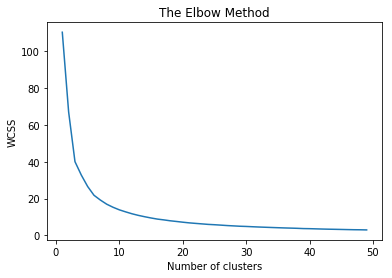

In [51]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []
for i in range(1,50):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(data2D)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,50),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow(k=30,70).png')
plt.show()

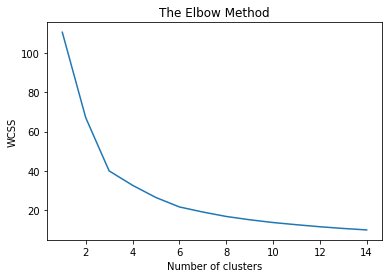

In [38]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(data2D)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow(k=20,25).png')
plt.show()

3.3 Use Optimal K-Value to run clustering

Load backup kmeans model

In [1]:
import pickle
with open('kmeans_model(K=3)(1)', 'rb') as f:
    kmeans = pickle.load(f)
true_k = 3

KeyboardInterrupt: 

In [30]:
from sklearn.cluster import MiniBatchKMeans, KMeans
true_k = 21

kmeans = MiniBatchKMeans(n_clusters=true_k, 
                         init='k-means++', 
                         n_init=10,
                         random_state=10,
                         init_size=1000, 
                         batch_size=1000,
                         verbose=True)

#kmeans = KMeans(n_clusters=true_k,init='k-means++',max_iter=300,n_init=10,random_state=42, verbose=True)
kmeans.fit(x)

import pickle
with open('kmeans_model(K='+ str(true_k)+ ')(1)', 'wb') as f: #94 24 15
    pickle.dump(kmeans, f)

Init 1/10 with method: k-means++
Inertia for init 1/10: 851.740772
Init 2/10 with method: k-means++
Inertia for init 2/10: 851.038562
Init 3/10 with method: k-means++
Inertia for init 3/10: 857.022257
Init 4/10 with method: k-means++
Inertia for init 4/10: 846.752609
Init 5/10 with method: k-means++
Inertia for init 5/10: 844.763022
Init 6/10 with method: k-means++
Inertia for init 6/10: 841.096882
Init 7/10 with method: k-means++
Inertia for init 7/10: 852.138904
Init 8/10 with method: k-means++
Inertia for init 8/10: 852.080320
Init 9/10 with method: k-means++
Inertia for init 9/10: 848.547553
Init 10/10 with method: k-means++
Inertia for init 10/10: 849.268781
Minibatch iteration 1/500: mean batch inertia: 0.881489, ewa inertia: 0.881489 
Minibatch iteration 2/500: mean batch inertia: 0.868851, ewa inertia: 0.876254 
Minibatch iteration 3/500: mean batch inertia: 0.865459, ewa inertia: 0.871782 
Minibatch iteration 4/500: mean batch inertia: 0.863784, ewa inertia: 0.868469 
Minibatc

In [31]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
top_terms = ""
top_terms_arr = []

for i in range(true_k):
    for ind in order_centroids[i, :15]:
        top_terms += terms[ind] + ', ' 
    print('Cluster %d:' % i + '>> ' + top_terms + '\n')
    top_terms_arr.append(top_terms)
    top_terms = ""

Cluster 0:>> sec, cloud, infrastruct, network, man, serv, architect, technolog, solv, vuln, system, techn, op, cert, cyb, 

Cluster 1:>> develop, design, softw, work, system, us, team, produc, solv, test, requir, cod, engin, program, technolog, 

Cluster 2:>> sec, soc, incid, advert, analys, inform, assess, threat, detect, job, op, cism, man, analyst, intrud, 

Cluster 3:>> test, autom, defect, cas, develop, man, requir, us, execut, qual, team, plan, work, script, softw, 

Cluster 4:>> busy, man, solv, market, custom, produc, work, team, cli, develop, abl, skil, sal, lead, requir, 

Cluster 5:>> dat, analys, busy, model, big, solv, man, us, team, machin, develop, skil, sci, learn, intellig, 

Cluster 6:>> network, support, serv, system, hardw, troubleshoot, provid, window, instal, comput, us, man, admin, softw, config, 

Cluster 7:>> project, man, team, requir, busy, plan, work, develop, ens, lead, budget, del, schedule, stakehold, commun, 

Cluster 8:>> infotech, greet, infotechposit,

In [21]:
import random
r = lambda: random.randint(0,255)

cluster_names = []
cluster_colors = []

for i in range(1,(true_k+1)):
    cluster_names.append(str(i) + ": " + top_terms_arr[i-1])
    cluster_colors.append('#%02X%02X%02X' % (r(),r(),r()))
print(cluster_names)
print(cluster_colors)

['1: sec, cloud, infrastruct, man, serv, architect, vuln, technolog, cyb, network, risk, solv, op, assess, techn, ', '2: develop, design, softw, apply, work, team, requir, test, technolog, solv, program, produc, skil, cod, techn, ', '3: sec, advert, cyb, job, cli, consult, daryl, threat, penet, pleas, searchelectcom, assess, inform, incid, soc, ', '4: incid, request, serv, support, resolv, ticket, level, custom, desk, provid, cal, esc, issu, man, techn, ', '5: test, autom, defect, cas, man, develop, qa, script, execut, selen, tool, plan, qual, softw, team, ', '6: dat, analys, busy, model, big, solv, man, team, develop, skil, work, machin, learn, etl, sci, ', '7: busy, requir, project, analys, develop, work, solv, test, docu, man, techn, support, abl, spec, process, ', '8: support, hardw, network, comput, softw, troubleshoot, requir, serv, instal, diplom, work, provid, rm, techn, typ, ', '9: account, fin, prep, tax, man, audit, report, busy, work, analys, company, ens, recont, pay, cust

C:\Users\uSER\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


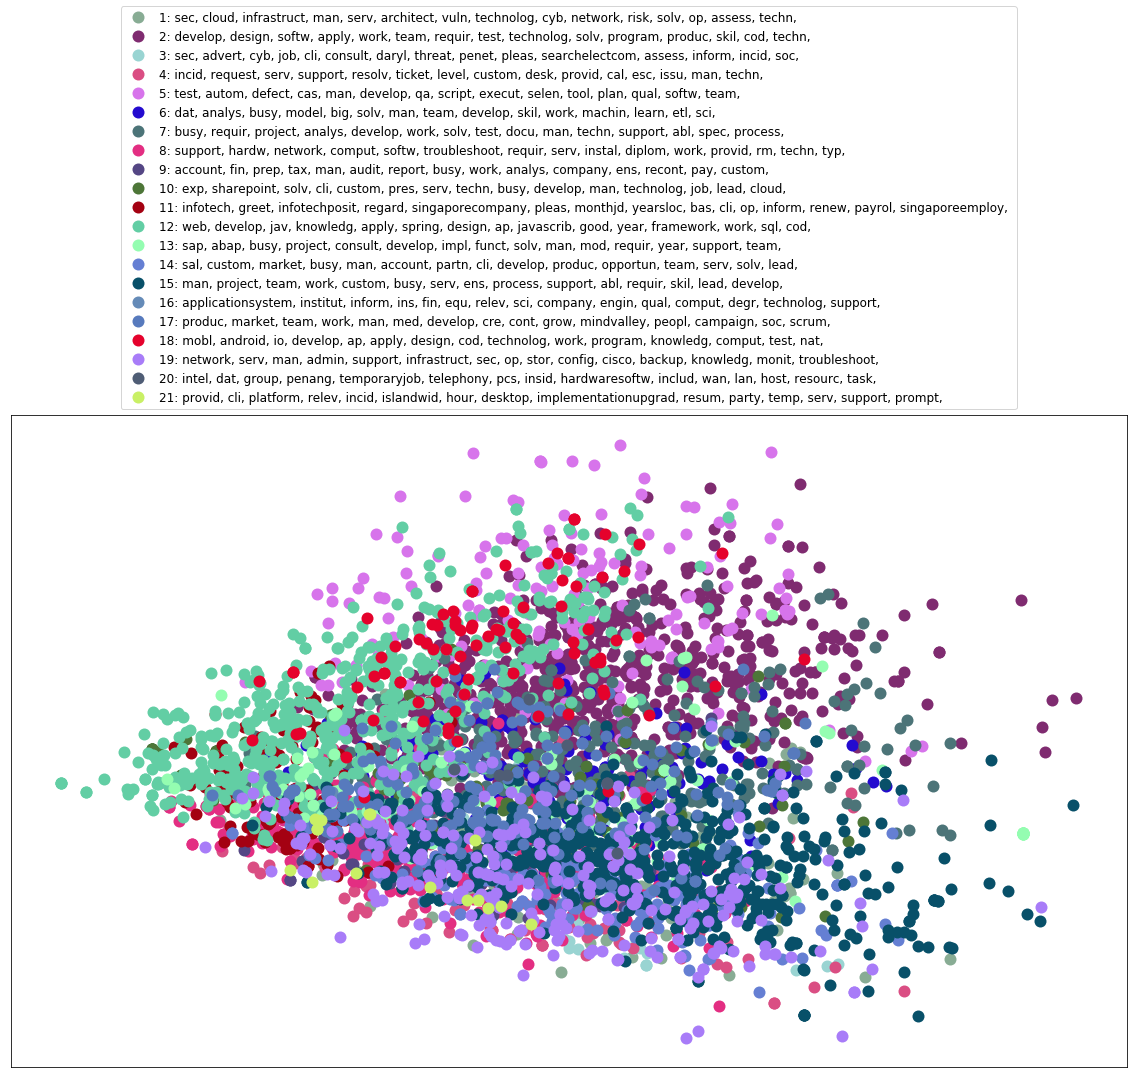

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
clusters = kmeans.labels_.tolist()
df = pd.DataFrame(dict(x=data2D[:, 0], y=data2D[:, 1], label=clusters)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(20, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
#ax.legend()  #show legend with only 1 point
ax.legend(numpoints=1, loc='lower center', bbox_to_anchor=(0.5, 1.00), prop={'size': 12})
#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], size=8)  

    
plt.show() #show the plot